In [1]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
#from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
#import untangle

import xml.etree.ElementTree as et
import pandas as pd
import re
from sklearn.metrics import f1_score
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import soundfile

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency   
    return frequencies, abs(fourier_transform)

# TODO: Funktion überarbeiten damit man es auch versteht!
def new_fft(data, rate):
    N = len(data)

    # sample spacing
    T = 1.0 / rate
    x = np.linspace(0.0, N*T, N)

    yf = fft(data)
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
    ampl = 2.0/N * np.abs(yf[0:N//2])
    return freq, ampl

# Frequency domain representation
def plot_freq_domain(freq, fourier, name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1400)
    plt.title(name)
    plt.show()

# TODO: Warnung herausgeben wenn bei der Teilung der Samplerate eine Fliesskommazahl entsteht
def easy_downsampling(data, rate, sampl_fac):
    ds_data = []
    for i in range(len(data)):
        if (i%sampl_fac == 0):
            ds_data.append(data[i])
    ds_rate = int(rate/sampl_fac)
    return ds_data, ds_rate

#ToDo: startwert von 0 nicht möglich überarbeiten!!
def snip_wav(data, rate, start_sec, end_sec):
    start_point = int((rate * start_sec)-1)
    end_point = int((rate * end_sec)-1)
    #print('start_point:', start_point)
    #print('end_point:', end_point)
    snip_data = data[start_point:end_point]
    #print(snip_data)  
    return snip_data, rate

# Berechnung Vector target
#def calc_target_vec(pitch):
#    pitch_start = 40
#    #pitch_end = 76
#    pitch_end = pitch_start + 77 #TODO: muss angepasst werden
#    target_vec = []
#    
#    if pitch_start <= pitch <= pitch_end:
#        for pitch_act in range(pitch_start, pitch_end+1):
#            
#            if pitch_act == pitch:
#                target_vec.append(1)
#            else:
#                target_vec.append(0)
#    else:
#        print('Pitch muss innerhalb der Range({} - {})!'.format(pitch_start, pitch_end))
#    
#    return target_vec

def calc_target_vec(pitch):
    pitch_start = 40
    pitch_end = 76
    #pitch_end = pitch_start + 77 #TODO: muss angepasst werden
    combi_vec = []
    for element in pitch:
        pitch_vec = []
        if pitch_start <= element <= pitch_end:
            for pitch_act in range(pitch_start, pitch_end+1):
                if pitch_act == element:
                    pitch_vec.append(1)
                else:
                    pitch_vec.append(0)
            combi_vec.append(pitch_vec)
        else:
            print('Pitch {} muss innerhalb der Range({} - {})!'.format(pitch, pitch_start, pitch_end))
            return[0] * (pitch_end - pitch_start + 1) # for harmonics
    target_vec = [sum(x) for x in zip(*combi_vec)]
    return target_vec

def metric(target_v, approx_v):
    norm_factor = np.linalg.norm(approx_v)
    if (norm_factor != 0):
        norm_v = approx_v/norm_factor
        diff = target_v - norm_v
        diff_sum = np.sum(np.abs(diff))
        return diff_sum
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return approx_v 
    
def norm_vec(vector):
    norm_factor = np.linalg.norm(vector)
    if (norm_factor != 0):
        norm_v = vector/norm_factor
        return norm_v
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return vector

## Dataframe 

- fft normieren 
- alle werte von fft quadrieren + summe bilden -> darf nicht mehr als 1 geben! 

In [3]:
def read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac):
    dataset = re.search(r'dataset.*\b', path).group(0)
    path_xml = path + "annotation"
    path_wav = path + "audio"  
    df = pd.DataFrame(columns=df_cols)
    
    for xml_file in sorted(glob.glob(os.path.join(path_xml, '*.xml'))):
        tree = et.parse(xml_file)
        root = tree.getroot()
        all_events = []
       
        for globalParam in root.findall('globalParameter'):
            audio_name = globalParam.find('audioFileName').text
            audio_name = audio_name.replace("\\", "")
            
            # Read wav-file
            wav_file = path_wav + '/' + audio_name
            data, rate = soundfile.read(wav_file)

        for transcription in root.findall('transcription'):

            for event in transcription.findall('event'):
                event_data = []
                event_data.append(dataset)
                event_data.append(audio_name)

                for elem in df_cols[len(event_data):]:
                    if event is not None:
                        if event.find(elem) is not None:
                            event_data.append(event.find(elem).text)
                            
                        elif elem == df_cols[3]:
                            onset_sec = event.find('onsetSec').text
                            event_data.append(onset_sec)
                            start_sec = round(offset_sec + float(onset_sec), 3)
                            end_sec = round(start_sec + duration_sec, 3)

                            # Snip and downsampling audio-file
                            data_snip, rate_snip = snip_wav(data, rate, start_sec, end_sec)
                            data_down, rate_down = easy_downsampling(data_snip, rate_snip, sampl_fac)

                            # Calc FFT
                            #freq, fourier = new_fft(data_down, rate_down)
                            freq, fourier = new_fft(date_snip, rate_snip)
                                                       
                        elif elem == 'amplitude':
                            event_data.append(fourier[:50])
                            #event_data.append(fourier[:50]*fourier[:50])


                        elif elem == 'frequency':
                            event_data.append(freq[:50])
                        else:
                            event_data.append(None)
                    else:
                        event_data.append(None)

                all_events.append({df_cols[i]: event_data[i] for i, _ in enumerate(df_cols)})
                
        combi_events = mono_poly_detection(all_events)
        df = df.append(pd.DataFrame(combi_events, columns=df_cols), ignore_index=True)
        
    return df

In [4]:
def mono_poly_detection(events):
    
    poly_time = 0.070
    
    dataset = events[0]['dataset']
    audioFileName = events[0]['audio_file_name']
    amp = events[0]['amplitude']
    freq = events[0]['frequency']
    
    onsets = []
    pitches = []
    combi_events = []

    
    for event in events:
        onsets.append(float(event['onset_sec']))
        pitches.append(int(event['pitch']))
        
    pitch_array = [pitches[0]]
    new_onset = onsets[0]
    

    for i in range(len(events)-1):
        if (onsets[i + 1]- onsets[i]) <= poly_time:
            pitch_array.append(pitches[i+1])
            new_onset = onsets[i+1]
            amp = events[i+1]['amplitude']
            freq = events[i+1]['frequency']
            
        else:
            combi_events.append({'dataset': dataset,
                               'audio_file_name': audioFileName,
                               'pitch': pitch_array,
                               'onset_sec': new_onset,
                               'amplitude': amp,
                               'frequency': freq,
                              })
            
            pitch_array = [pitches[i+1]]
            new_onset = onsets[i+1]
            amp = events[i+1]['amplitude']
            freq = events[i+1]['frequency']
            
    combi_events.append({'dataset': dataset,
                   'audio_file_name': audioFileName,
                   'pitch': pitch_array,
                   'onset_sec': new_onset,
                   'amplitude': amp,
                   'frequency': freq,
                  })

    return combi_events

# Init Dataframe

In [5]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.05
sampl_fac = 1

# Create empty Dataframe
df_cols = ['dataset', 'audio_file_name', 'pitch', 'onset_sec', 'amplitude', 'frequency']
df_ref = pd.DataFrame(columns=df_cols)
df_test = pd.DataFrame(columns=df_cols)

# Create Dataframe with reference tones

In [6]:
%%time
# paths
path_main = "IDMT-SMT-GUITAR_V2/"
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"
#path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC Chords/"

df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, sampl_fac)
df_ref.head(10)
#df_ref.pitch

CPU times: user 463 ms, sys: 82 ms, total: 545 ms
Wall time: 782 ms


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009527075804280047, 0.012250241045892342, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
6,dataset1/Fender Strat Clean Neck SC,G53-45200-1111-00014.wav,[45],0.2,"[0.001084571198270975, 0.002188941124022176, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
7,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.004128384752338435, 0.002491926601108584, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
8,dataset1/Fender Strat Clean Neck SC,G53-46201-1111-00015.wav,[46],0.2,"[0.00517525532348356, 0.0037794923178455474, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
9,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.002118874893707483, 0.0004992268356448354, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


In [7]:
#new
#df_test.amplitude
#np.linalg.norm(df_test.amplitude[0])
#np.linalg.norm(df_test.amplitude[0]).sum()
#df_test.amplitude[0].sum()


In [13]:
# new useful

def normalise(vector):
    norm_factor = np.linalg.norm(vector)
    if (norm_factor != 0):
        norm_v = vector/np.linalg.norm(vector)
        return norm_v
    
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return vector



# Create Dataframe with testdatas

In [9]:
%%time
# paths testdata
# ToDO: Automatisieren #os.listdir(path_main + path_dataset)

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/']

# dataset2:
# [Errno 2] No such file or directory: 'IDMT-SMT-GUITAR_V2/dataset2/audio/\\AR_A_fret_1-20.wav'
# in xml file den audionamen angepasst AR_A_fret_1-20.wav --> AR_A_fret_0-20.wav
# Alle 0-20 und Lick11
# Gesamthaft mussten 27 von 261 XML-Dateien überarbeitet werden

for path in path_testdata:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac)
    df_test = df_test.append(df_act, ignore_index=True)
df_test

CPU times: user 11.9 s, sys: 1.44 s, total: 13.4 s
Wall time: 18.4 s


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2000,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2000,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2000,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2000,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2000,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
...,...,...,...,...,...,...
4448,dataset2,LP_V_vibrato_slow-fast.wav,[60],43.0498,"[0.002487341671033241, 0.004921049887680139, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4449,dataset2,LP_V_vibrato_slow-fast.wav,[64],49.6065,"[0.0050438371645350035, 0.0022661671921127076,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4450,dataset2,LP_V_vibrato_slow-fast.wav,[64],55.5450,"[0.0024214063371930804, 0.002211863439550683, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4451,dataset2,LP_V_vibrato_slow-fast.wav,[69],62.3891,"[0.0031924125558935325, 0.002750274986731963, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


#new
# euklidische norm
norm_factor = np.linalg.norm(df_test.amplitude[0])
if (norm_factor != 0):
    norm_v = df_test.amplitude[0]/np.linalg.norm(df_test.amplitude[0])
norm2 = normalize(df_test.amplitude[0][:,np.newaxis], norm='l2',axis=0).ravel() 
#norm2.sum()

#print(np.all(norm_v == norm2)) 
print(norm2)

In [14]:
x_vec = []
for vector in range(len(df_test.amplitude)):
    vect = normalise(df_test.amplitude[vector])

    x_vec.append(vect)
df_test['norm_amp'] = x_vec
    
    #df_test['new_norm_amp'] = normalise(df_test.amplitude[vector])
#n1=normalise(df_test.amplitude[0])
#print(np.all(n1 == norm2)) 
# thresholding vec_pred


In [15]:
df_test.amplitude

0       [0.01021836468962585, 0.007419197032659204, 0....
1       [0.0005969542765022676, 0.0017092017487395916,...
2       [0.0034228128100198415, 0.00428068727065624, 0...
3       [0.0007040495234552155, 0.001659174406915279, ...
4       [0.0048971509176587305, 0.006496422462073519, ...
                              ...                        
4448    [0.002487341671033241, 0.004921049887680139, 0...
4449    [0.0050438371645350035, 0.0022661671921127076,...
4450    [0.0024214063371930804, 0.002211863439550683, ...
4451    [0.0031924125558935325, 0.002750274986731963, ...
4452    [0.0016533059057464946, 0.004889505665010828, ...
Name: amplitude, Length: 4453, dtype: object

In [16]:
df_test

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2000,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10127093336080213, 0.07352928096683563, 0.0..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2000,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005746382481390451, 0.016453064116849166, 0..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2000,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0397638081924387, 0.049729984375395025, 0.0..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2000,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005936822970793429, 0.013990812298524002, 0..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2000,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.045924833920309806, 0.06092259104596529, 0...."
...,...,...,...,...,...,...,...
4448,dataset2,LP_V_vibrato_slow-fast.wav,[60],43.0498,"[0.002487341671033241, 0.004921049887680139, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.023542567143982108, 0.04657749626792105, 0...."
4449,dataset2,LP_V_vibrato_slow-fast.wav,[64],49.6065,"[0.0050438371645350035, 0.0022661671921127076,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.2770987260245116, 0.1244988728637649, 0.093..."
4450,dataset2,LP_V_vibrato_slow-fast.wav,[64],55.5450,"[0.0024214063371930804, 0.002211863439550683, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.05109533157431361, 0.04667365989136426, 0.0..."
4451,dataset2,LP_V_vibrato_slow-fast.wav,[69],62.3891,"[0.0031924125558935325, 0.002750274986731963, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10500248677063863, 0.0904600228992372, 0.06..."


In [17]:
df_test['square_amplitude'] = np.square(df_test.amplitude)

In [18]:
df_test['square_norm_amp'] = np.square(df_test.norm_amp)

In [19]:
df_test

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp,square_amplitude,square_norm_amp
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2000,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10127093336080213, 0.07352928096683563, 0.0...","[0.0001044149769301924, 5.504448460941914e-05,...","[0.010255801943768026, 0.005406555159499856, 0..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2000,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005746382481390451, 0.016453064116849166, 0...","[3.563544082343458e-07, 2.921370617894478e-06,...","[3.302091162243108e-05, 0.0002707033188331496,..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2000,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0397638081924387, 0.049729984375395025, 0.0...","[1.1715647532435924e-05, 1.8324283509158366e-0...","[0.0015811604419650551, 0.0024730713459770333,..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2000,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005936822970793429, 0.013990812298524002, 0...","[4.95685731477516e-07, 2.752859712562668e-06, ...","[3.5245866986540515e-05, 0.0001957428287725304..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2000,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.045924833920309806, 0.06092259104596529, 0....","[2.3982087110325746e-05, 4.220350480573336e-05...","[0.0021090903706080383, 0.0037115620997539302,..."
...,...,...,...,...,...,...,...,...,...
4448,dataset2,LP_V_vibrato_slow-fast.wav,[60],43.0498,"[0.002487341671033241, 0.004921049887680139, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.023542567143982108, 0.04657749626792105, 0....","[6.1868685884584345e-06, 2.421673199703671e-05...","[0.0005542524677289058, 0.0021694631585881994,..."
4449,dataset2,LP_V_vibrato_slow-fast.wav,[64],49.6065,"[0.0050438371645350035, 0.0022661671921127076,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.2770987260245116, 0.1244988728637649, 0.093...","[2.5440293342344505e-05, 5.135513742607994e-06...","[0.07678370396440733, 0.015499969344347896, 0...."
4450,dataset2,LP_V_vibrato_slow-fast.wav,[64],55.5450,"[0.0024214063371930804, 0.002211863439550683, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.05109533157431361, 0.04667365989136426, 0.0...","[5.86320864979881e-06, 4.892339875220977e-06, ...","[0.0026107329086890495, 0.002178430527654745, ..."
4451,dataset2,LP_V_vibrato_slow-fast.wav,[69],62.3891,"[0.0031924125558935325, 0.002750274986731963, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10500248677063863, 0.0904600228992372, 0.06...","[1.0191497927026677e-05, 7.5640125026435e-06, ...","[0.01102552222801814, 0.00818301574293052, 0.0..."


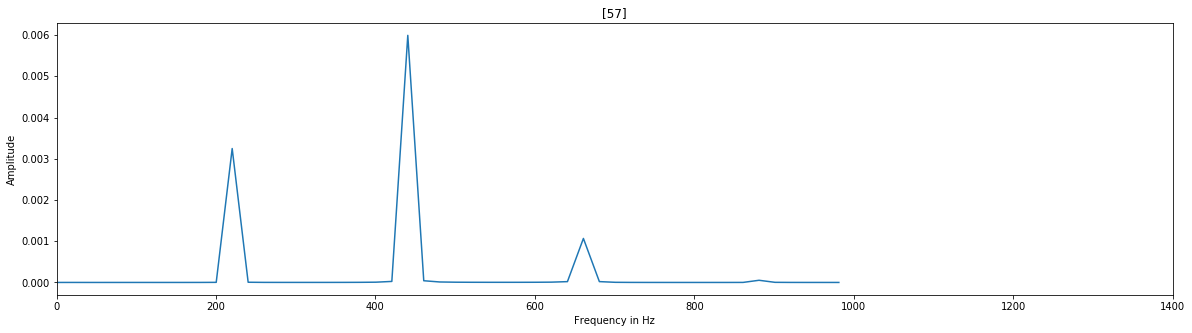

50

In [20]:
pitch = 36
plot_freq_domain(df_test.frequency[pitch], df_test.square_amplitude[pitch], df_test.pitch[pitch])
len(df_test.amplitude[pitch])


In [21]:
# drop duplicate in df_ref
df_ref_unique = pd.DataFrame(columns=df_cols)
 
for index, row in df_ref.iterrows():
    if not df_ref_unique.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_unique = df_ref_unique.append(row, ignore_index=True)
df_ref_unique

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009527075804280047, 0.012250241045892342, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
6,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.004128384752338435, 0.002491926601108584, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
7,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.002118874893707483, 0.0004992268356448354, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
8,dataset1/Fender Strat Clean Neck SC,G53-48108-1111-00009.wav,[48],0.2,"[0.004706986961451247, 0.003622570456490808, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
9,dataset1/Fender Strat Clean Neck SC,G53-49109-1111-00010.wav,[49],0.2,"[0.002570064484126984, 0.0007081923531536819, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


In [22]:
y_vec = []
for vector in range(len(df_ref_unique.amplitude)):
    vect = normalise(df_ref_unique.amplitude[vector])

    y_vec.append(vect)
df_ref_unique['norm_amp'] = y_vec
df_ref_unique['square_amplitude'] = np.square(df_ref_unique.amplitude)

In [23]:

df_ref_unique['square_norm_amp'] = np.square(df_ref_unique.norm_amp)
df_ref_unique

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp,square_amplitude,square_norm_amp
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10127093336080213, 0.07352928096683563, 0.0...","[0.0001044149769301924, 5.504448460941914e-05,...","[0.010255801943768026, 0.005406555159499856, 0..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005746382481390451, 0.016453064116849166, 0...","[3.563544082343458e-07, 2.921370617894478e-06,...","[3.302091162243108e-05, 0.0002707033188331496,..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0397638081924387, 0.049729984375395025, 0.0...","[1.1715647532435924e-05, 1.8324283509158366e-0...","[0.0015811604419650551, 0.0024730713459770333,..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005936822970793429, 0.013990812298524002, 0...","[4.95685731477516e-07, 2.752859712562668e-06, ...","[3.5245866986540515e-05, 0.0001957428287725304..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.045924833920309806, 0.06092259104596529, 0....","[2.3982087110325746e-05, 4.220350480573336e-05...","[0.0021090903706080383, 0.0037115620997539302,..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009527075804280047, 0.012250241045892342, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0660483728036843, 0.08492726458317884, 0.09...","[9.076517338049829e-05, 0.0001500684056824655,...","[0.004362387550014463, 0.007212640269581263, 0..."
6,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.004128384752338435, 0.002491926601108584, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.04007589954270565, 0.02419013878908851, 0.0...","[1.7043560663340484e-05, 6.20969818531258e-06,...","[0.001606077724157035, 0.0005851628146353646, ..."
7,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.002118874893707483, 0.0004992268356448354, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.016801734127920322, 0.003958646443420209, 0...","[4.489630815183898e-06, 2.4922743342795553e-07...","[0.0002822982697053225, 1.567088166400347e-05,..."
8,dataset1/Fender Strat Clean Neck SC,G53-48108-1111-00009.wav,[48],0.2,"[0.004706986961451247, 0.003622570456490808, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.03657423826366318, 0.028148103253243777, 0....","[2.2155726255272047e-05, 1.3123016712240022e-0...","[0.0013376749045672035, 0.0007923157167552729,..."
9,dataset1/Fender Strat Clean Neck SC,G53-49109-1111-00010.wav,[49],0.2,"[0.002570064484126984, 0.0007081923531536819, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.018495234520737782, 0.005096441641159745, 0...","[6.605231452570901e-06, 5.015364090653494e-07,...","[0.00034207369997709053, 2.5973717401747037e-0..."


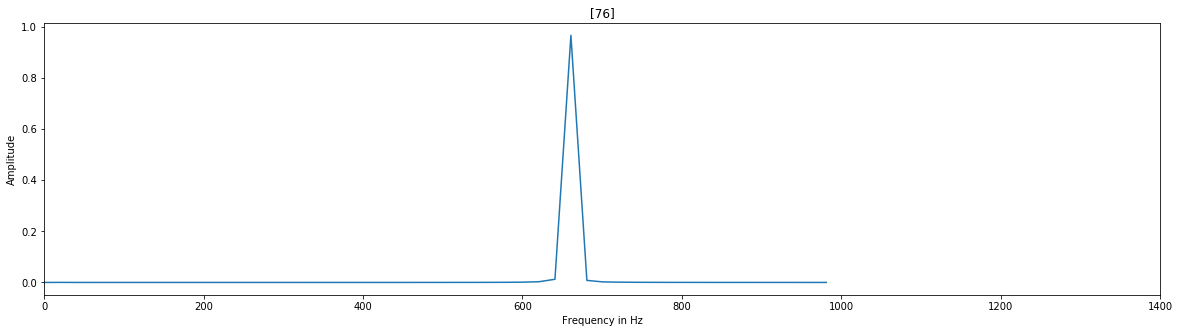

50

In [24]:
pitch = 36
plot_freq_domain(df_ref_unique.frequency[pitch], df_ref_unique.square_norm_amp[pitch], df_ref_unique.pitch[pitch])
len(df_ref_unique.amplitude[pitch])


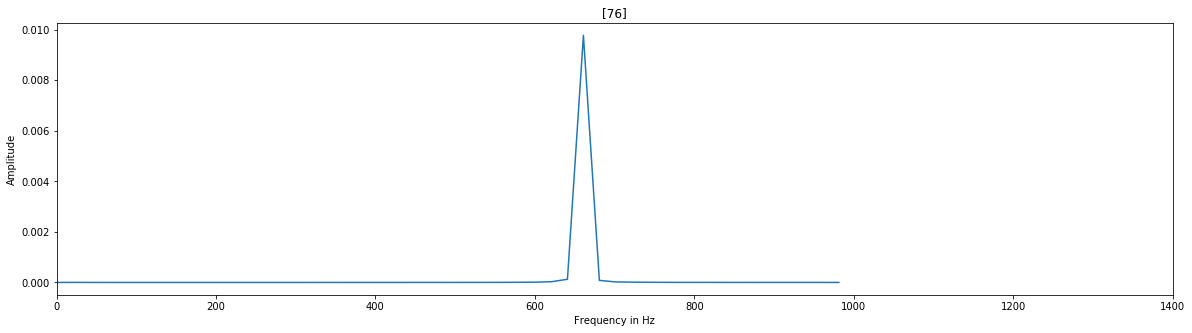

50

In [25]:
pitch = 36
plot_freq_domain(df_ref_unique.frequency[pitch], df_ref_unique.square_amplitude[pitch], df_ref_unique.pitch[pitch])
len(df_ref_unique.amplitude[pitch])


# Create Dataframe with testdatas

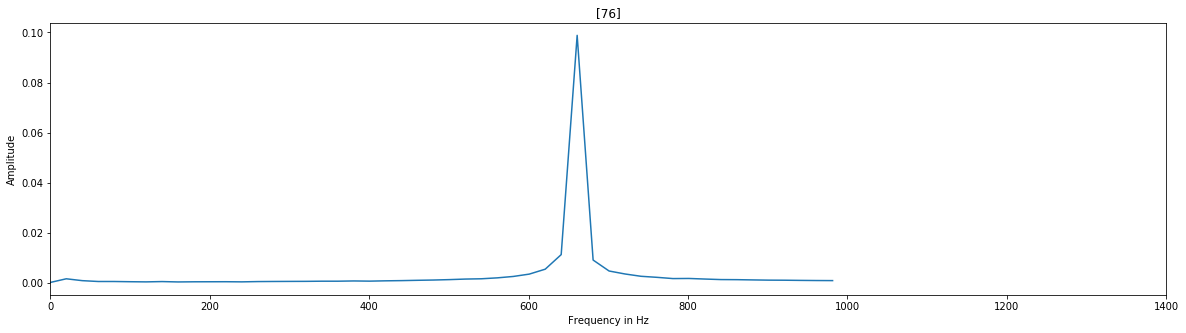

50

In [26]:
pitch = 36
plot_freq_domain(df_ref_unique.frequency[pitch], df_ref_unique.amplitude[pitch], df_ref_unique.pitch[pitch])
len(df_ref.amplitude[pitch])


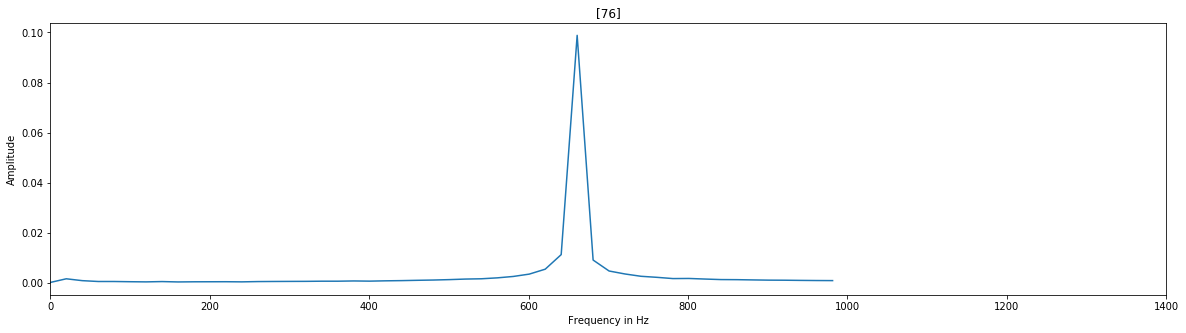

50

In [27]:
#new
pitch = 36
plot_freq_domain(df_ref_unique.frequency[pitch], df_ref_unique.amplitude[pitch], df_ref_unique.pitch[pitch])
len(df_ref.amplitude[pitch])


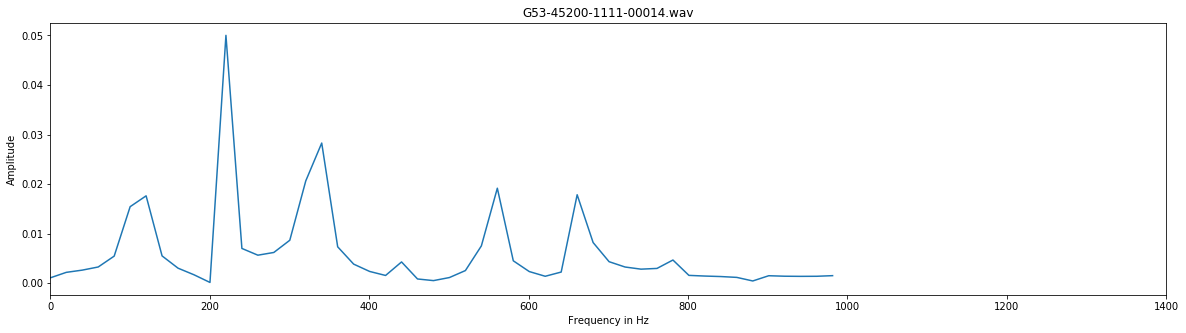

In [28]:
pitch = 6
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.audio_file_name[pitch])

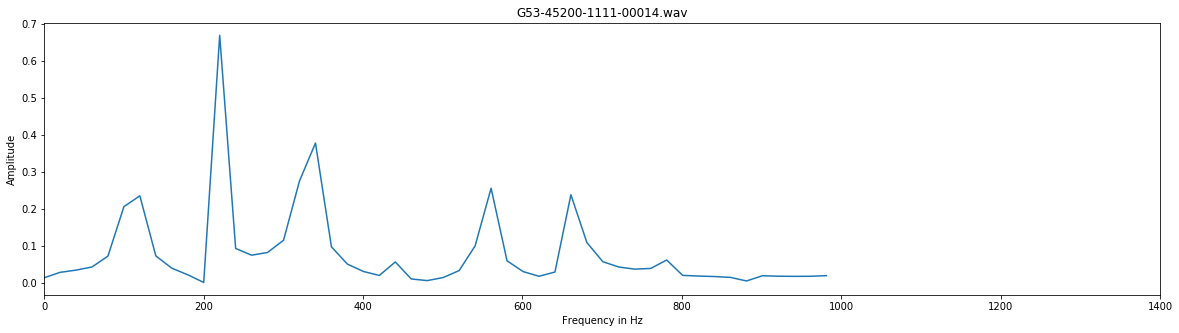

In [29]:
pitch = 6
plot_freq_domain(df_test.frequency[pitch], df_test.norm_amp[pitch], df_test.audio_file_name[pitch])

## Histogram of Pitches Distribution

pitch min: 40
pitch max: 92


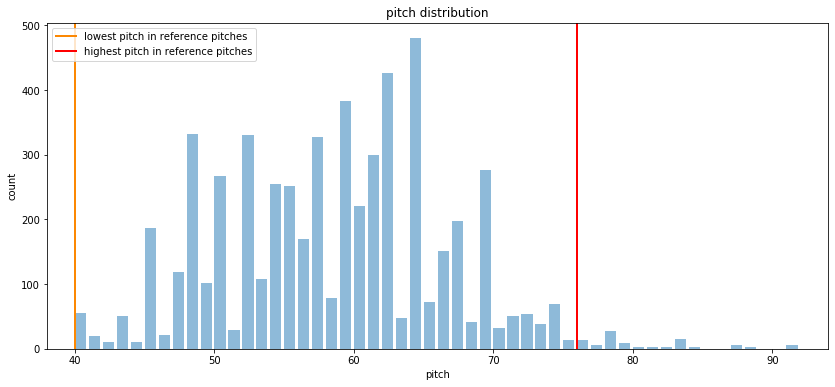

In [30]:
all_pitches_temp = df_test.pitch.tolist()
 
# flatten List
all_pitches = []
for sublist in all_pitches_temp:
    for item in sublist:
        all_pitches.append(item)
        
# plot figure        
plt.figure(figsize=(14,6)) 
bins = np.arange(min(all_pitches), max(all_pitches)+1)
plt.xlim([min(all_pitches)-2, max(all_pitches)+2])
 
    
min_pitch = min(all_pitches)   
max_pitch = max(all_pitches)
print('pitch min:',min_pitch)
print('pitch max:', max_pitch)

ref_min = min(df_ref_unique.pitch)
ref_max = max(df_ref_unique.pitch)

plt.hist(all_pitches, bins = bins, range=[min_pitch,max_pitch], alpha=0.5, width=0.8)
plt.axvline(linewidth=2, color='#fc8803', x=ref_min, label='lowest pitch in reference pitches')
plt.axvline(linewidth=2, color='r', x=ref_max, label='highest pitch in reference pitches')
plt.title('pitch distribution')
plt.xlabel('pitch')
plt.ylabel('count')
plt.legend(loc = 'upper left')

# Gurobi

In [32]:
# Build Model
m = Model('AMt')

lambs = []
for lamb in range(len(df_ref_unique)):
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [33]:
'''
%%time
#Optimize Signal

deviation = 0
approxi_sgn = 0
 
for sgn in range(len(mischsignal)):
#for sgn in range(100):
    for lamb in range(len(lambs)):
        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]
        
    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))
    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'
    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden
    # Überprüfen ob der Betrag der Differenz besser geeignet ist?
print('Deviation is calculated.')
'''

"\n%%time\n#Optimize Signal\n\ndeviation = 0\napproxi_sgn = 0\n \nfor sgn in range(len(mischsignal)):\n#for sgn in range(100):\n    for lamb in range(len(lambs)):\n        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]\n        \n    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))\n    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'\n    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden\n    # Überprüfen ob der Betrag der Differenz besser geeignet ist?\nprint('Deviation is calculated.')\n"

In [34]:
%%time
pred_vec = []

len_lambs = len(lambs)

#amplitudes = df_test.amplitude.tolist()
###norm_amplitudes = df_test.norm_amp.tolist()
sq_norm_amplitudes = df_test.square_norm_amp

#m.reset()

#for index, row in df_test.iterrows():
##for amplitude in amplitudes:
###for norm_amplitude in norm_amplitudes:
for sq_norm_amplitude in sq_norm_amplitudes:
    #mischsignal = row.Amplitude
    ##mischsignal = amplitude
    mischsignal = sq_norm_amplitude

    ###mischsignal = norm_amplitude

    len_mischsignal = len(mischsignal)
    #print(row.audioFileName)


    # Schlaufen vertauscht
    cost_function = 0
    approxi_sgn = 0  
    #print(type(cost_function))
    #cost_function = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'CostFunction')
    #approxi_sgn = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'approxi_sgn')

    for lamb in range(len_lambs):
        la = lambs[lamb]
        note = df_ref_unique.square_norm_amp[lamb]
        

        for sgn in range(len_mischsignal):
            approxi_sgn = la * note[sgn]
            mi = mischsignal[sgn]
            
            
            deviation = mi - approxi_sgn
            #print(type(mi))
            
            cost_function += deviation * deviation
            #cost_function += ((mi - approxi_sgn)*(mi - approxi_sgn))
    #print('Cost Function is created')

    #Params
    m.params.outputflag = 0 # Infotext ausblenden
    #m.params.presolve = 0
    
    m.setObjective(cost_function, GRB.MINIMIZE)
    m.optimize()



    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        approx_v.append(v.x)

    pred_vec.append(approx_v)

CPU times: user 8min 26s, sys: 14.5 s, total: 8min 40s
Wall time: 9min 38s


In [35]:
df_test['pred_vec'] = pred_vec

# Calculate Pitch Score

In [36]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(pitch))

df_test['target_vec'] = target_vec
df_test.head()

Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [80] muss innerhalb der Range(40 - 76)!
Pitch [81] muss innerhalb der Range(40 - 76)!
Pitch [82] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [84] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Range(40 - 76)!
Pitch [92] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Rang

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp,square_amplitude,square_norm_amp,pred_vec,target_vec
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10127093336080213, 0.07352928096683563, 0.0...","[0.0001044149769301924, 5.504448460941914e-05,...","[0.010255801943768026, 0.005406555159499856, 0...","[1.0, 0.20567292126570466, 0.20708037618700065...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005746382481390451, 0.016453064116849166, 0...","[3.563544082343458e-07, 2.921370617894478e-06,...","[3.302091162243108e-05, 0.0002707033188331496,...","[0.273856108001688, 0.9999999999999997, 1.0718...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0397638081924387, 0.049729984375395025, 0.0...","[1.1715647532435924e-05, 1.8324283509158366e-0...","[0.0015811604419650551, 0.0024730713459770333,...","[0.17062199906861927, 0.66325905980405, 1.0000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005936822970793429, 0.013990812298524002, 0...","[4.95685731477516e-07, 2.752859712562668e-06, ...","[3.5245866986540515e-05, 0.0001957428287725304...","[0.03910413835256625, 0.11305313378166575, 0.5...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.045924833920309806, 0.06092259104596529, 0....","[2.3982087110325746e-05, 4.220350480573336e-05...","[0.0021090903706080383, 0.0037115620997539302,...","[0.09725837177934321, 0.14464969633124924, 0.5...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
pitch_score = []
#vec_target = df_test.pitch.array

for vec in range(len(pred_vec)):
    pitch_score.append(metric(target_vec[vec], pred_vec[vec]))
    
df_test['pitch_score'] = pitch_score
df_test.head()

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp,square_amplitude,square_norm_amp,pred_vec,target_vec,pitch_score
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10127093336080213, 0.07352928096683563, 0.0...","[0.0001044149769301924, 5.504448460941914e-05,...","[0.010255801943768026, 0.005406555159499856, 0...","[1.0, 0.20567292126570466, 0.20708037618700065...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.889688
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005746382481390451, 0.016453064116849166, 0...","[3.563544082343458e-07, 2.921370617894478e-06,...","[3.302091162243108e-05, 0.0002707033188331496,...","[0.273856108001688, 0.9999999999999997, 1.0718...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.925168
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0397638081924387, 0.049729984375395025, 0.0...","[1.1715647532435924e-05, 1.8324283509158366e-0...","[0.0015811604419650551, 0.0024730713459770333,...","[0.17062199906861927, 0.66325905980405, 1.0000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.084898
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005936822970793429, 0.013990812298524002, 0...","[4.95685731477516e-07, 2.752859712562668e-06, ...","[3.5245866986540515e-05, 0.0001957428287725304...","[0.03910413835256625, 0.11305313378166575, 0.5...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.799379
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.045924833920309806, 0.06092259104596529, 0....","[2.3982087110325746e-05, 4.220350480573336e-05...","[0.0021090903706080383, 0.0037115620997539302,...","[0.09725837177934321, 0.14464969633124924, 0.5...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.944411


# Calculate F1 Score

In [118]:
#x = df_test.Vec_Pred_Norm[0]
#np.amax(x)
max_val = []
for i in df_test.norm_pred_vec:
    max_val.append(np.amax(i))
    
threshold = min(max_val)
print('optimal threshold for binarizing vec pred is: ', threshold)

optimal threshold for binarizing vec pred is:  0.2604853824856412


In [119]:
# thresholding vec_pred
%time
thresholded_vec = []
norm_pred_vec = []
#v_pred = df_test.pred_vec

for j in range(len(pred_vec)):
    thresh_vec = []
    vec = norm_vec(pred_vec[j])
    
    for i in range(len(vec)):
        if vec[i]> threshold:
            thresh_vec.append(1)
        else:
            thresh_vec.append(0)
            
    thresholded_vec.append(thresh_vec)
    norm_pred_vec.append(vec)
    
df_test['thresholded_vec'] = thresholded_vec
df_test['norm_pred_vec'] = norm_pred_vec

df_test.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp,square_amplitude,square_norm_amp,pred_vec,target_vec,pitch_score,thresholded_vec,norm_pred_vec,mono_poly
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.10127093336080213, 0.07352928096683563, 0.0...","[0.0001044149769301924, 5.504448460941914e-05,...","[0.010255801943768026, 0.005406555159499856, 0...","[1.0, 0.20567292126570466, 0.20708037618700065...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.889688,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0.7162207622651902, 0.14730721644623143, 0.14...",1
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005746382481390451, 0.016453064116849166, 0...","[3.563544082343458e-07, 2.921370617894478e-06,...","[3.302091162243108e-05, 0.0002707033188331496,...","[0.273856108001688, 0.9999999999999997, 1.0718...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.925168,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.1466458061772922, 0.5354848838222306, 0.573...",1
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0397638081924387, 0.049729984375395025, 0.0...","[1.1715647532435924e-05, 1.8324283509158366e-0...","[0.0015811604419650551, 0.0024730713459770333,...","[0.17062199906861927, 0.66325905980405, 1.0000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.084898,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.10732798630502606, 0.41721618358664564, 0.6...",1
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005936822970793429, 0.013990812298524002, 0...","[4.95685731477516e-07, 2.752859712562668e-06, ...","[3.5245866986540515e-05, 0.0001957428287725304...","[0.03910413835256625, 0.11305313378166575, 0.5...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.799379,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.021230142242047008, 0.06137800785825069, 0....",1
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.045924833920309806, 0.06092259104596529, 0....","[2.3982087110325746e-05, 4.220350480573336e-05...","[0.0021090903706080383, 0.0037115620997539302,...","[0.09725837177934321, 0.14464969633124924, 0.5...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.944411,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06453936907308093, 0.0959876251991129, 0.33...",1


In [120]:
df_test.sort_values(by = 'pitch_score', ascending = False)

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,norm_amp,square_amplitude,square_norm_amp,pred_vec,target_vec,pitch_score,thresholded_vec,norm_pred_vec,mono_poly
2034,dataset2,FS_Lick10_MN.wav,"[43, 55, 59, 50, 67, 62]",12.4183,"[0.0013161039676796013, 0.00702739597007568, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.009264070506498332, 0.04946591860720852, 0....","[1.732129653741989e-06, 4.938429412023591e-05,...","[8.582300234937226e-05, 0.002446877103654978, ...","[0.3191759746389288, 0.15870375915765617, 0.28...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",9.357421,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4237373486351753, 0.2106947748807737, 0.380...",6
3384,dataset2,LP_Lick10_MN.wav,"[45, 52, 64, 69, 57, 60]",8.4332,"[0.0032718495176492636, 0.003842125523128084, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.02954173384972065, 0.03469079155664148, 0.0...","[1.0704999266141718e-05, 1.4761928535472252e-0...","[0.0008727140388477308, 0.001203451018826348, ...","[0.06796135475278943, 0.13180772945264332, 0.2...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",9.292773,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.10185556009891276, 0.19754388589809432, 0.3...",6
3353,dataset2,LP_Lick10_FN.wav,"[59, 50, 55, 62, 43, 67]",10.0172,"[0.005080271307843613, 0.0099701257993743, 0.0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.03987430672692589, 0.07825405970277481, 0.0...","[2.5809156561299057e-05, 9.940340845534901e-05...","[0.0015899603369529676, 0.006123697859965444, ...","[0.10940102566242953, 0.12814927473181267, 0.1...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",9.255932,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0.2036398557076483, 0.2385379813160938, 0.358...",6
683,dataset2,AR_Lick10_MN.wav,"[43, 50, 59, 55, 62, 67]",9.4607,"[0.007012376763653053, 0.002201136631799419, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.04611345769694509, 0.014474695866569765, 0....","[4.917342787542126e-05, 4.8450024718492915e-06...","[0.002126450980767944, 0.00020951682042969183,...","[0.21590819484121518, 0.13441247875186563, 0.2...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",9.017577,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0.2961140426182143, 0.18434419541518943, 0.35...",6
666,dataset2,AR_Lick10_KN.wav,"[45, 52, 57, 60, 64, 69]",9.4389,"[0.00205720752274909, 0.00032636566167505677, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.011466647084953272, 0.0018191260831450756, ...","[4.232102791655447e-06, 1.0651454512059761e-07...","[0.00013148399537086736, 3.3092197063787446e-0...","[0.19892152520883166, 0.06025602497277854, 0.0...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",8.958298,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0.32733048238994994, 0.09915283778632915, 0.1...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,dataset1/Ibanez Power Strat Clean Bridge HU,G53-73609-1111-309.wav,[73],0.2000,"[0.0005380781870039683, 0.009628706529540414, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.014194346346779433, 0.254002482636943, 0.06...","[2.895281353294775e-07, 9.27119894320142e-05, ...","[0.00020147946821233066, 0.06451726118573055, ...","[0.009758745052711596, 0.010518641354210732, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.535229,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.008319940396398773, 0.008967799511660724, 0...",1
77,dataset1/Fender Strat Clean Neck SC,G53-76612-1111-00078.wav,[76],0.2000,"[4.9464772888322e-05, 0.0015106828376955158, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.000492159772300734, 0.015030844740710049, 0...","[2.446763756893275e-09, 2.282162636107776e-06,...","[2.4222124147111036e-07, 0.0002259262936193309...","[0.0020999799281963788, 0.0010849173387664545,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.518402,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0

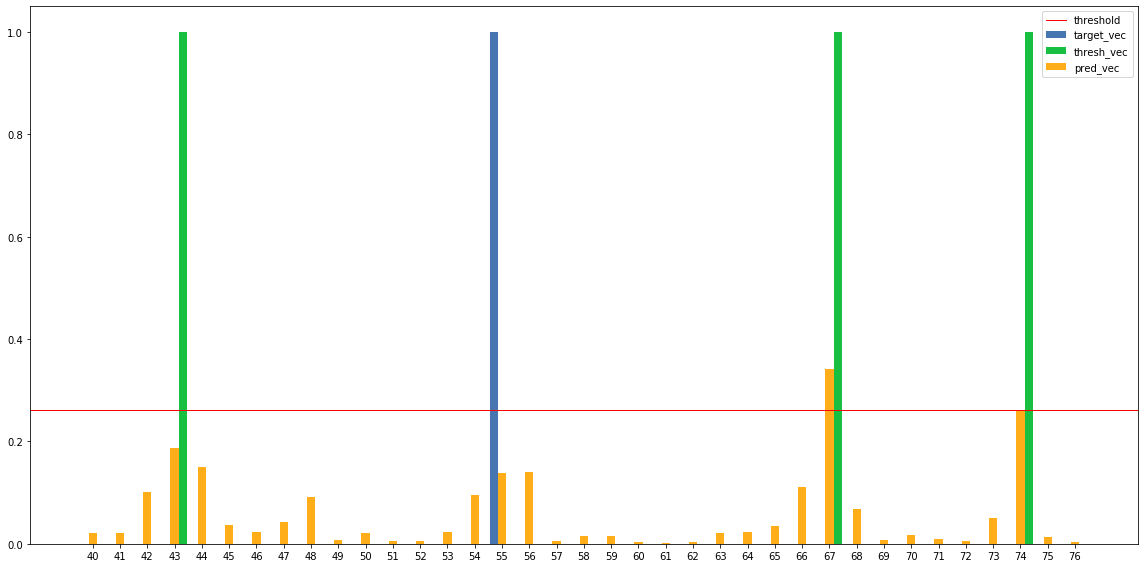

In [158]:
pitch_list = np.arange(40, 77, 1)
pitch_list

test_tone = 152

#create plot
fig, ax = plt.subplots(figsize = (16, 8))
index = len(pitch_list)-1

bar_width = 0.3
opacity = 0.9

target_rects = plt.bar(pitch_list, df_test.target_vec[test_tone], 
                       bar_width, alpha = opacity, label='target_vec', color='#3266a8')

thresh_rects = plt.bar(pitch_list + 2*bar_width, df_test.thresholded_vec[test_tone], 
                       bar_width, alpha = opacity, label='thresh_vec', color='#00b82b')

pred_rects = plt.bar(pitch_list + bar_width, df_test.pred_vec[test_tone], 
                     bar_width, alpha = opacity, label='pred_vec',color='orange')


plt.axhline(linewidth=1, color='r', y=threshold, label='threshold')

plt.xticks(pitch_list + bar_width, pitch_list)
plt.tight_layout()
plt.legend()

In [136]:
combi_target_vec = []
for i in df_test.target_vec:
    for elem in i:
        combi_target_vec.append(elem)
#print(target_vecs)

combi_pred_vec = []
for i in df_test.thresholded_vec:
    for elem in i:
        combi_pred_vec.append(elem)


# Save/Load Dataframe

In [147]:
df_test.to_pickle('file_name')


In [128]:
#df_test = pd.read_pickle('file_name')

# Scores

In [130]:
df_test['mono_poly'] = df_test.pitch.apply(lambda x: len(x))
pitch_score_mono = df_test.loc[df_test.mono_poly == 1].pitch_score.mean()
pitch_score_poly = df_test.loc[df_test.mono_poly > 1].pitch_score.mean()
mono_count = len(df_test.loc[df_test.mono_poly==1])
poly_count = len(df_test.loc[df_test.mono_poly>1])
total_count = mono_count + poly_count
anteil_mono = mono_count/total_count
anteil_poly = poly_count/total_count
total_pitch_score = pitch_score_mono*anteil_mono  + pitch_score_poly*anteil_poly

print('Possible number of Pichtes', df_test.mono_poly.unique())

print('Anzahl Monos: ', mono_count)
print('Anzahl Polys: ', poly_count)
print('Anzahl Files: ', total_count)

print('Pitch Score Mono: ', round(pitch_score_mono, 2))
print('Pitch Score Poly: ', round(pitch_score_poly, 2))

print('Total Pitch Score: ', round(total_pitch_score, 3))


Possible number of Pichtes [1 6 5 3 2 4]
Anzahl Monos:  3942
Anzahl Polys:  511
Anzahl Files:  4453
Pitch Score Mono:  3.73
Pitch Score Poly:  6.06
Total Pitch Score:  3.996


In [131]:
print(classification_report(combi_target_vec, combi_pred_vec))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    159168
           1       0.24      0.56      0.34      5593

    accuracy                           0.93    164761
   macro avg       0.61      0.75      0.65    164761
weighted avg       0.96      0.93      0.94    164761

